In [491]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import the necessary packages

In [492]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 150)

In [493]:
def removeArtifacts(data, original):
    for col in data.select_dtypes(include='object').columns:
        data[col] = data[col].where(data[col].isin(original[col].unique()), np.nan)
# remove categorical artifacts

In [494]:
def handleOriginal(original):
    original["Depression"] = (original["Depression"] == "Yes")

In [495]:
original = pd.read_csv("original.csv")
train = pd.read_csv("train.csv")
train_artifacts = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

handleOriginal(original)

removeArtifacts(train, original)
removeArtifacts(test, original)
# remove odd artifacts based on the original dataset

data = pd.concat([train, test]).reset_index(drop=True)

In [496]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234500 entries, 0 to 234499
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     234500 non-null  int64  
 1   Name                                   234061 non-null  object 
 2   Gender                                 234500 non-null  object 
 3   Age                                    234500 non-null  float64
 4   City                                   234352 non-null  object 
 5   Working Professional or Student        234500 non-null  object 
 6   Profession                             173144 non-null  object 
 7   Academic Pressure                      46664 non-null   float64
 8   Work Pressure                          187804 non-null  float64
 9   CGPA                                   46664 non-null   float64
 10  Study Satisfaction                     46664 non-null   

In [497]:
data.isna().sum().sort_values(ascending=False)

Study Satisfaction                       187836
Academic Pressure                        187836
CGPA                                     187836
Depression                                93800
Profession                                61356
Work Pressure                             46696
Job Satisfaction                          46684
Name                                        439
Degree                                      202
City                                        148
Sleep Duration                              133
Dietary Habits                               57
Financial Stress                              4
Working Professional or Student               0
Age                                           0
Gender                                        0
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Family History of Mental Illness              0
id                                            0
dtype: int64

In [498]:
def show_missing_values(data, palette="viridis"):
    missing_values = data.isna().sum().sort_values(ascending=False)
    sns.barplot(x=missing_values.values, y=missing_values.index,palette=palette)

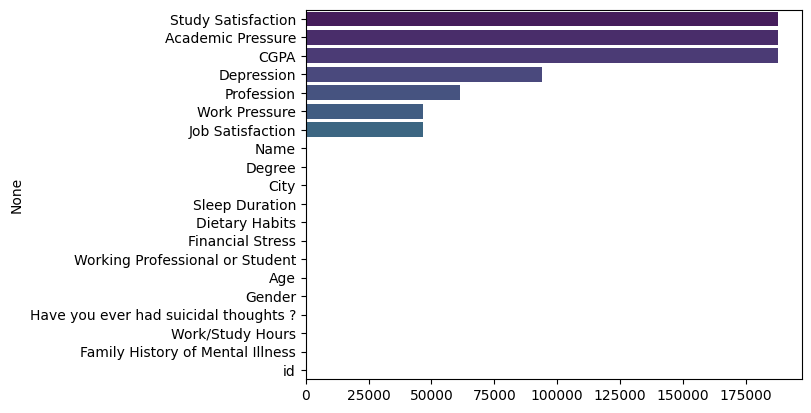

In [499]:
show_missing_values(data)

<Axes: ylabel='Count'>

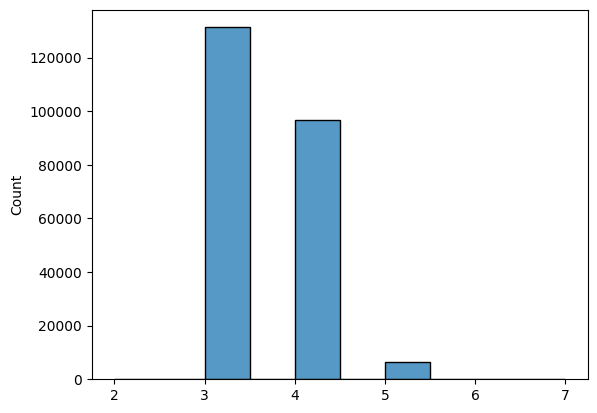

In [500]:
sns.histplot(data.isnull().sum(axis=1), bins=10)

<Axes: >

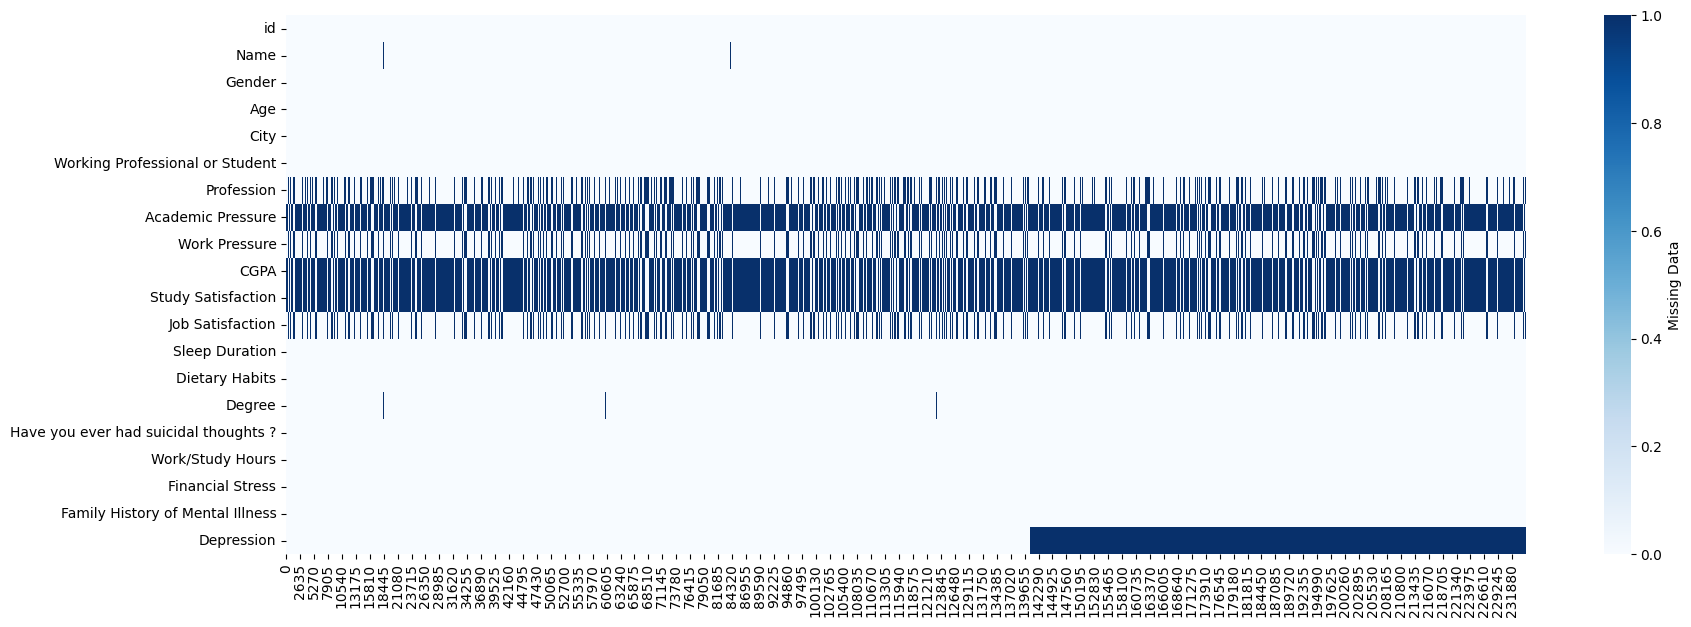

In [501]:
fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(data.isna().transpose(),cbar_kws={'label': 'Missing Data'},cmap="Blues",ax=ax)

Most missing values have 2 or more if missing value exists within the row. Likely, the columns are correlated with each other in some way.

<Axes: xlabel='Depression', ylabel='count'>

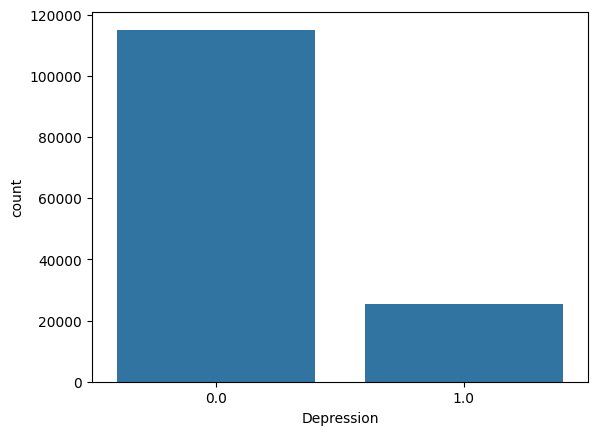

In [502]:
sns.countplot(data, x="Depression")

<Axes: xlabel='Work/Study Hours', ylabel='count'>

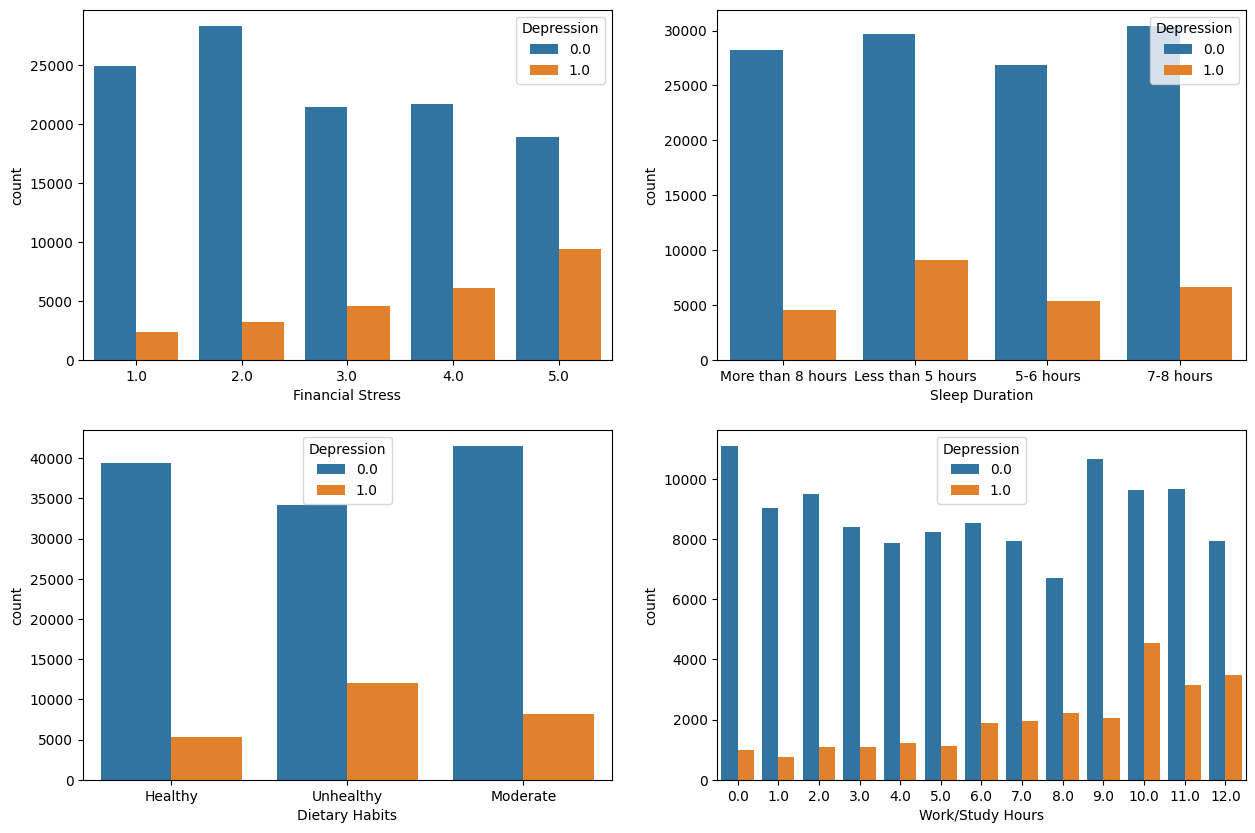

In [503]:
fig, axes=plt.subplots(ncols=2,nrows=2,figsize=(15,10))

sns.countplot(data,x="Financial Stress",hue="Depression",ax=axes[0][0])
sns.countplot(data,x="Sleep Duration",hue="Depression",ax=axes[0][1])
sns.countplot(data,x="Dietary Habits",hue="Depression",ax=axes[1][0])
sns.countplot(data,x="Work/Study Hours",hue="Depression",ax=axes[1][1])

In [504]:
data['Financial Stress'] = data['Financial Stress'].transform(lambda x: x.fillna(x.mode()[0])).astype('category')
data['Sleep Duration'] = data['Sleep Duration'].transform(lambda x: x.fillna(x.mode()[0]))
data['Dietary Habits'] = data['Dietary Habits'].transform(lambda x: x.fillna(x.mode()[0]))
data['Degree'] = data.groupby(by=["Working Professional or Student"])['Degree'].transform(lambda x: x.fillna(x.mode()[0]))
data['City'] = data['City'].transform(lambda x: x.fillna(x.mode()[0]))

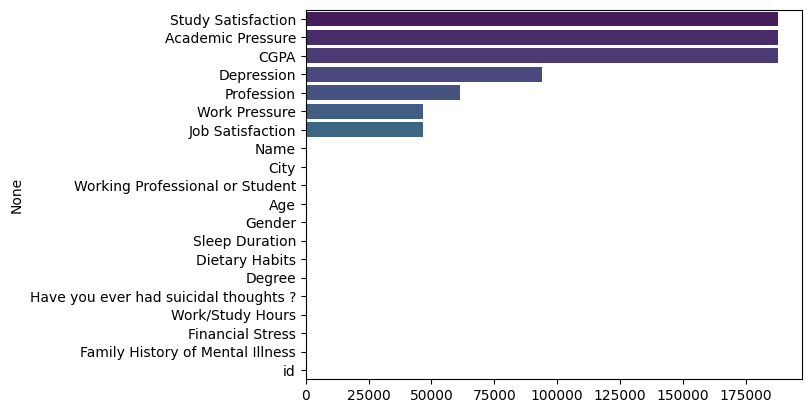

In [505]:
show_missing_values(data)

In [506]:
data["Name"] = data["Name"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')
data["Job Satisfaction"] = data["Job Satisfaction"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')
data["Work Pressure"] = data["Work Pressure"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')
data["Profession"] = data["Profession"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')

<Axes: xlabel='Work Pressure', ylabel='count'>

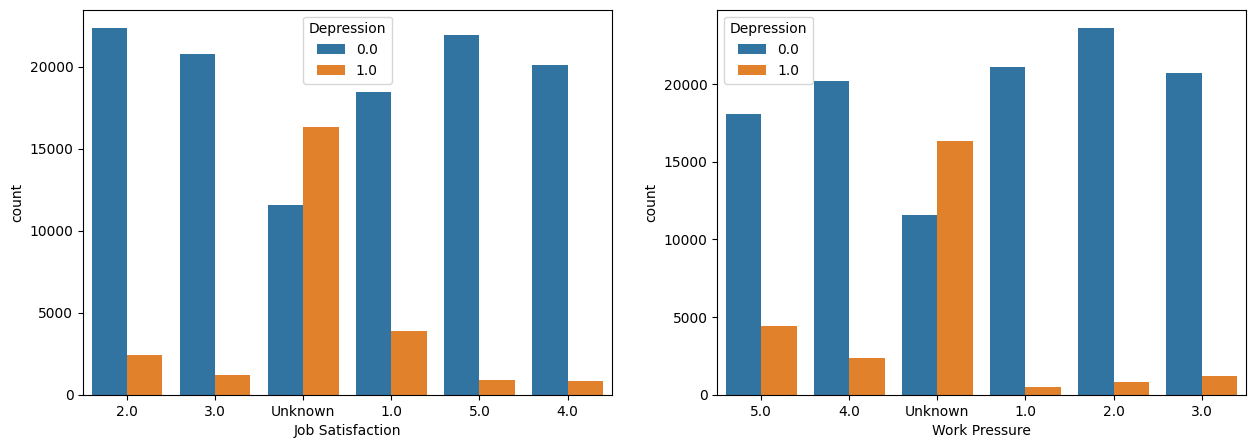

In [507]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.countplot(data,x="Job Satisfaction",hue="Depression",ax=axes[0])
sns.countplot(data,x="Work Pressure",hue="Depression",ax=axes[1])

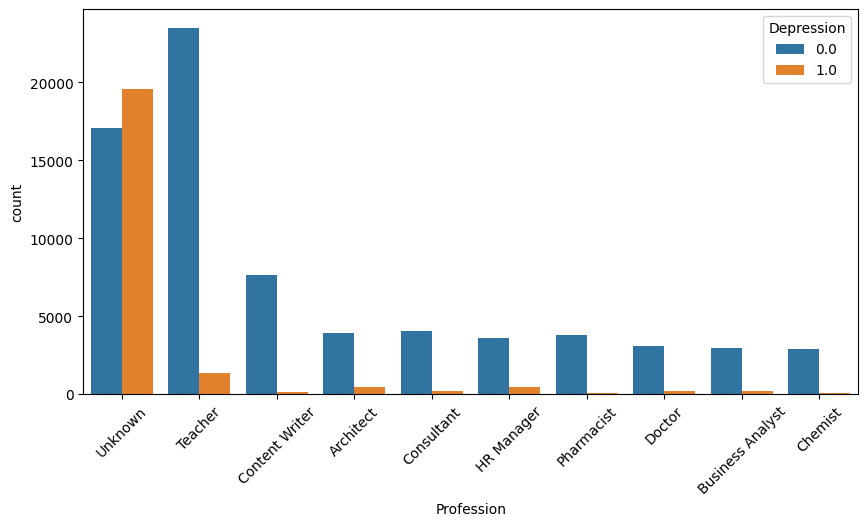

In [508]:
fig, axs = plt.subplots(ncols=1, nrows=1,figsize=(10,5))
sns.countplot(data,x="Profession",hue="Depression",order=data["Profession"].value_counts().iloc[:10].index,ax=axs)
axs.tick_params(axis='x', rotation=45)

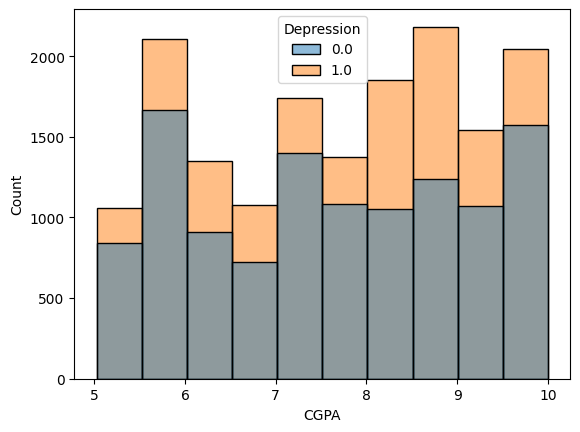

In [509]:
cgpa_bins = 10
sns.histplot(data,x="CGPA",hue="Depression",bins=cgpa_bins)
data["CGPA"] = pd.cut(data["CGPA"],bins=cgpa_bins).astype('object')

In [510]:
data["CGPA"] = data["CGPA"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')
data["Academic Pressure"] = data["Academic Pressure"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')
data["Study Satisfaction"] = data["Study Satisfaction"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')

<Axes: xlabel='Study Satisfaction', ylabel='count'>

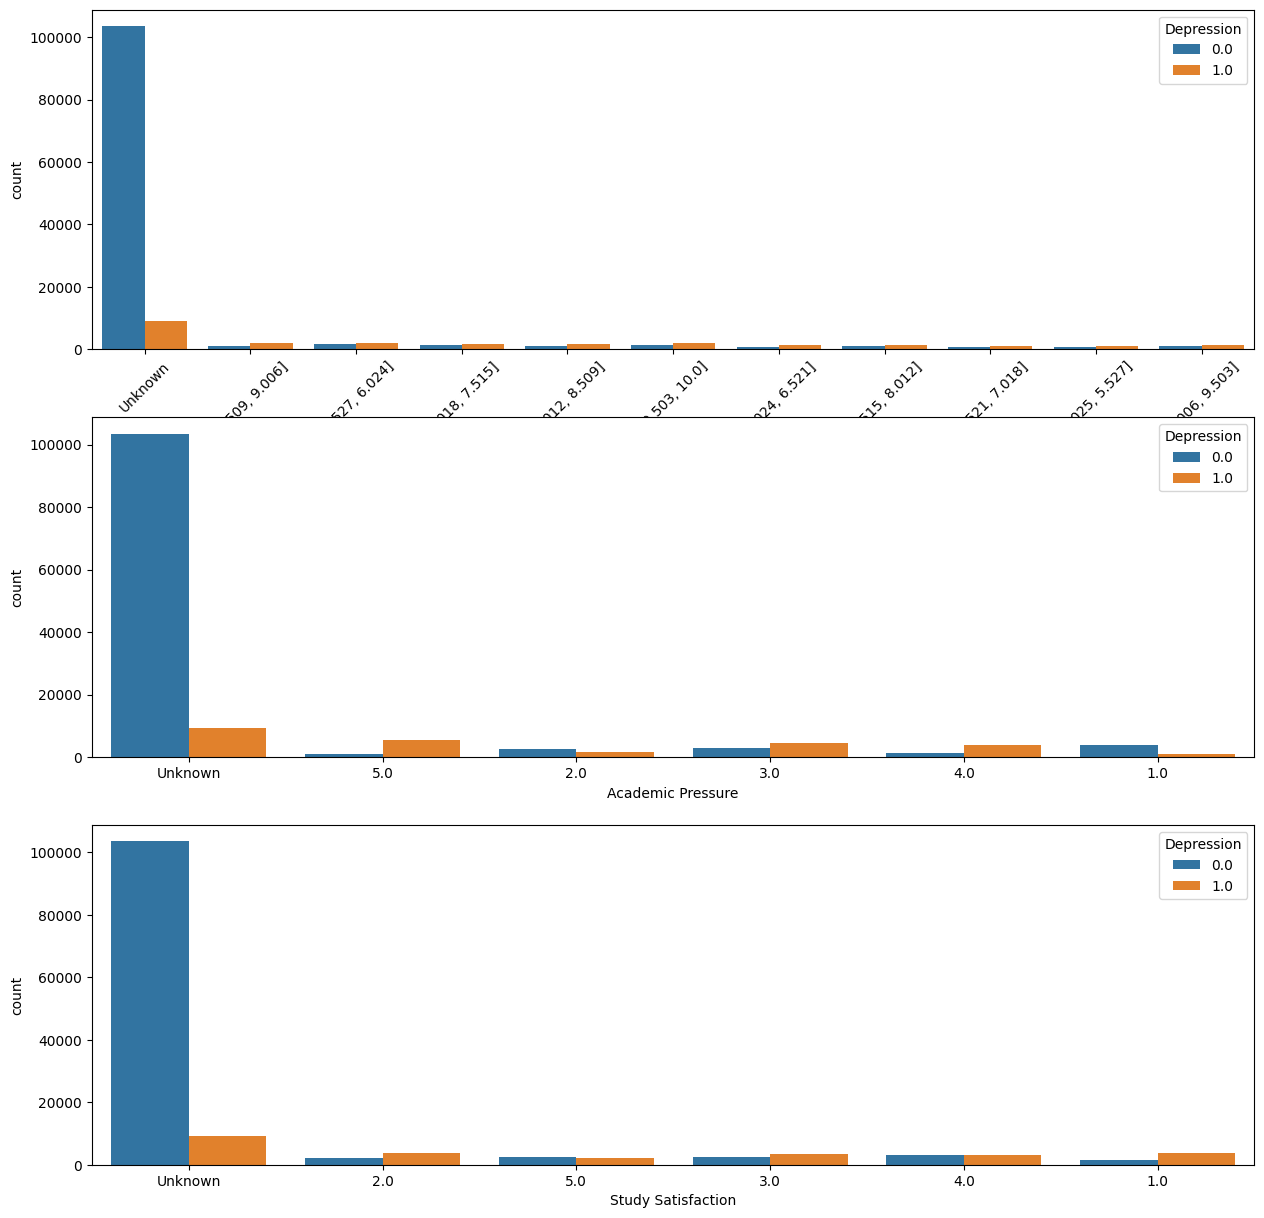

In [511]:
fig, axs = plt.subplots(ncols=1, nrows=3,figsize=(15,15))
sns.countplot(data,x="CGPA",hue="Depression",ax=axs[0])
axs[0].tick_params(axis='x', rotation=45)
sns.countplot(data,x="Academic Pressure",hue="Depression",ax=axs[1])
sns.countplot(data,x="Study Satisfaction",hue="Depression",ax=axs[2])

(0.0, 10000.0)

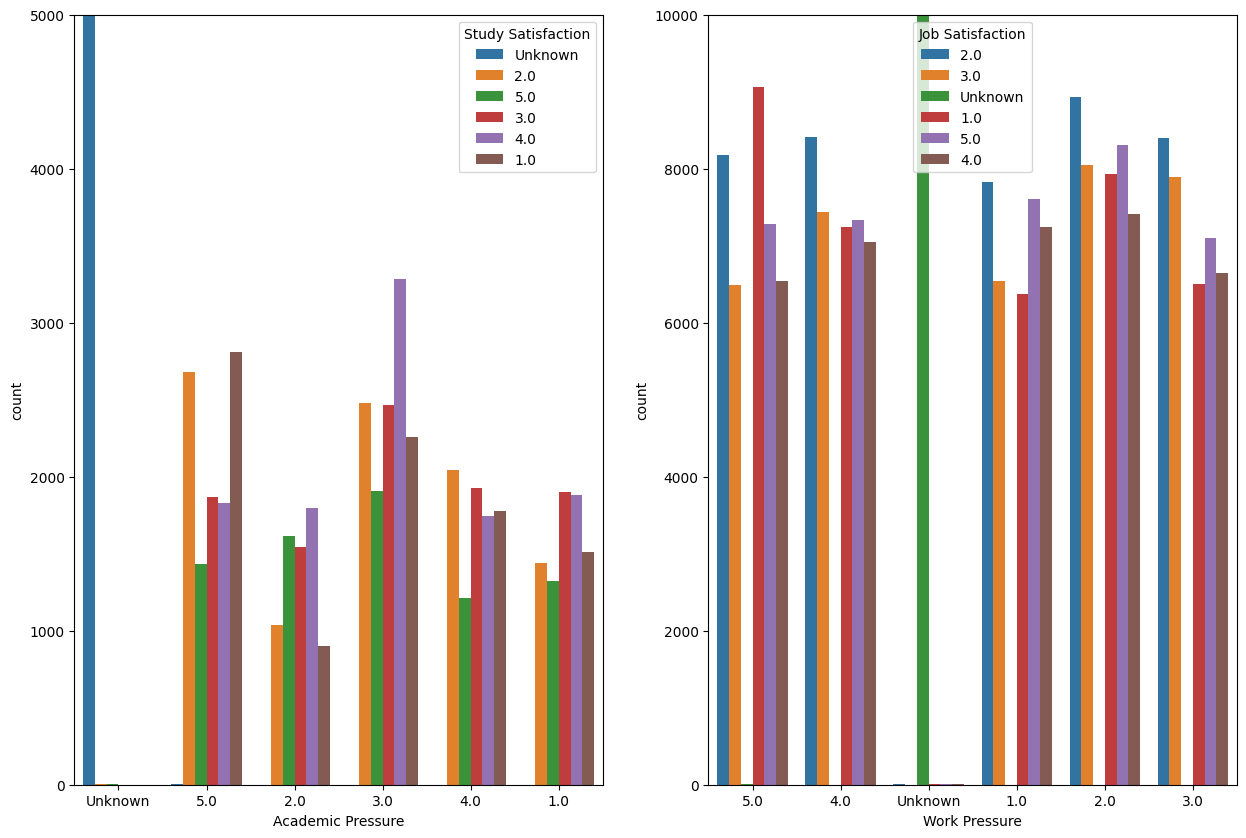

In [22]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

sns.countplot(data,x="Academic Pressure",hue="Study Satisfaction",ax=axs[0])
sns.countplot(data,x="Work Pressure",hue="Job Satisfaction",ax=axs[1])

axs[0].set_ylim(0, 5000)
axs[1].set_ylim(0, 10000)

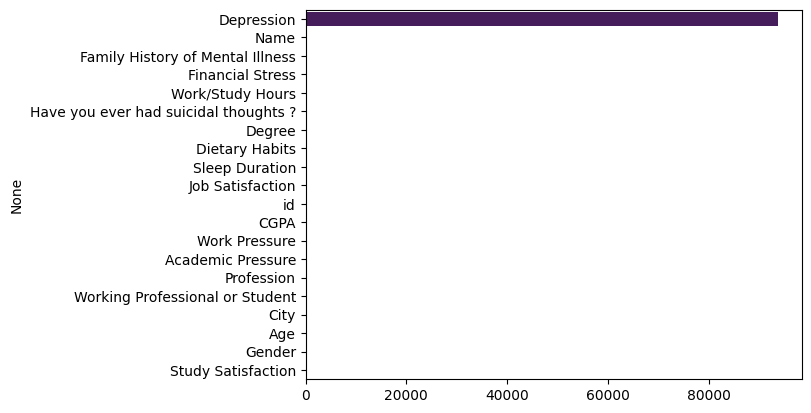

In [513]:
show_missing_values(data)

In [514]:
data_corr = pd.DataFrame(data)
oe = LabelEncoder()

for col in data_corr.select_dtypes(include='object').columns:
    if col == "Depression":
        continue
    data_corr[col] = oe.fit_transform(data_corr[col])

In [515]:
data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,Unknown,5.0,Unknown,Unknown,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0.0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,Unknown,4.0,Unknown,Unknown,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1.0
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,Unknown,5.0,Unknown,"(8.509, 9.006]",2.0,Unknown,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1.0
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,Unknown,5.0,Unknown,Unknown,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1.0
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,Unknown,1.0,Unknown,Unknown,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0.0


In [516]:
data_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234500 entries, 0 to 234499
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   id                                     234500 non-null  int64   
 1   Name                                   234500 non-null  int32   
 2   Gender                                 234500 non-null  int32   
 3   Age                                    234500 non-null  float64 
 4   City                                   234500 non-null  int32   
 5   Working Professional or Student        234500 non-null  int32   
 6   Profession                             234500 non-null  int32   
 7   Academic Pressure                      234500 non-null  int32   
 8   Work Pressure                          234500 non-null  int32   
 9   CGPA                                   234500 non-null  int32   
 10  Study Satisfaction                     23450

<Axes: >

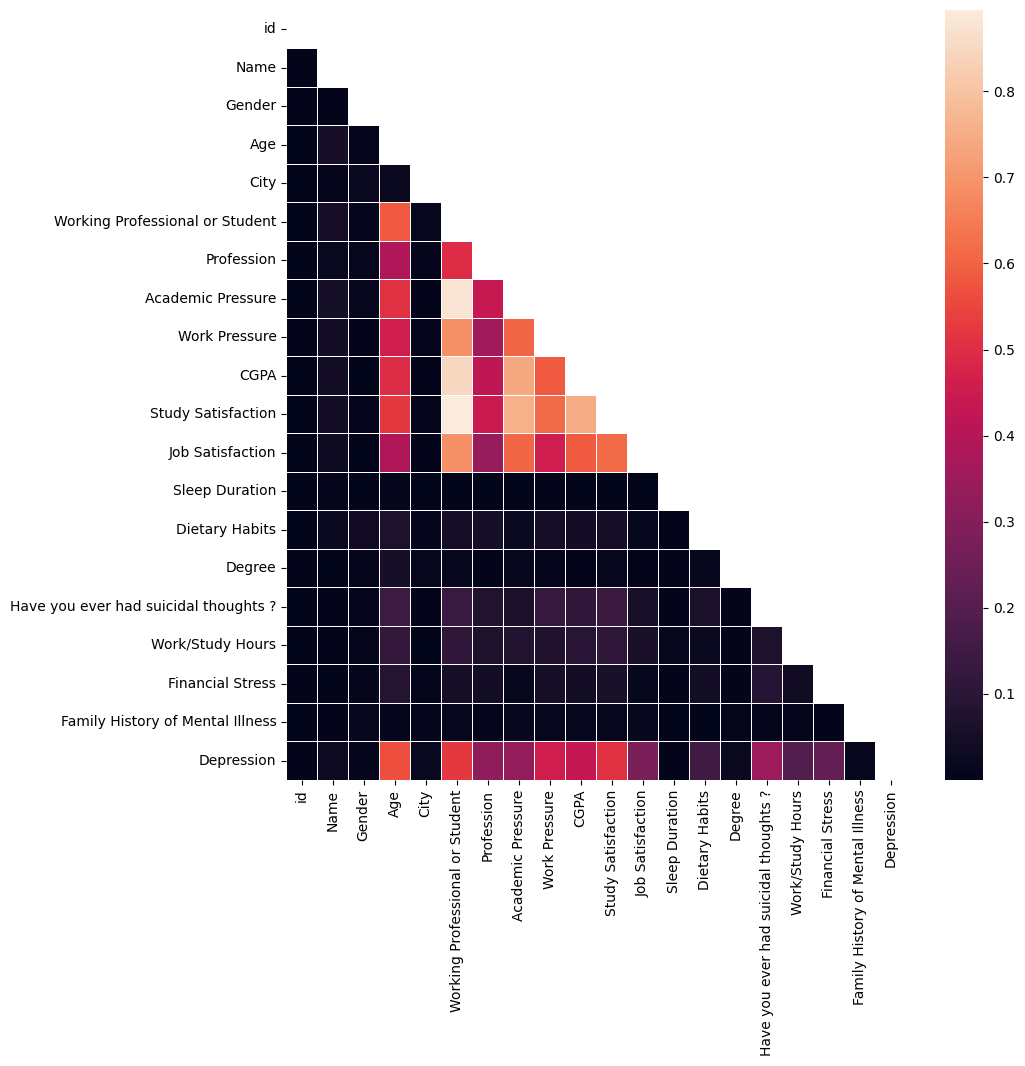

In [517]:
f, ax = plt.subplots(figsize=(10, 10))

corr = data_corr.corr().abs()
matrix_mask = np.triu(np.ones_like(corr)) # only show the upper triangular for the correlation matrix
sns.heatmap(corr, linewidths=.5, mask=matrix_mask)

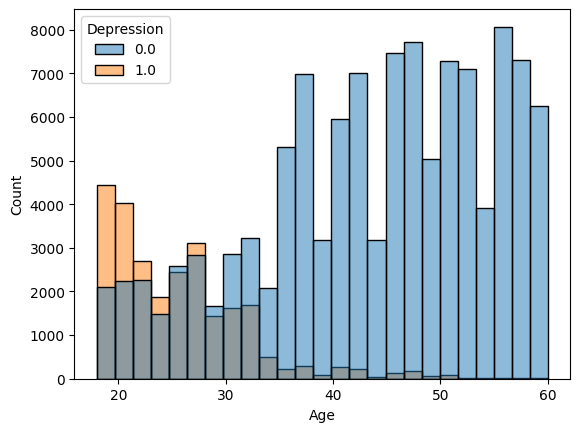

In [518]:
age_bins = 25
sns.histplot(data,x="Age",bins=age_bins,hue="Depression")
data["Age"] = pd.cut(data["Age"],bins=age_bins)

In [519]:
data['Name_CE'] = data['Name'].map(data['Name'].value_counts()) # count encode name. most likely useless since depression isn't likely tied to name
data = data.drop("Name",axis=1)

In [520]:
data['City_CE'] = data['City'].map(data['City'].value_counts()) # count encode city

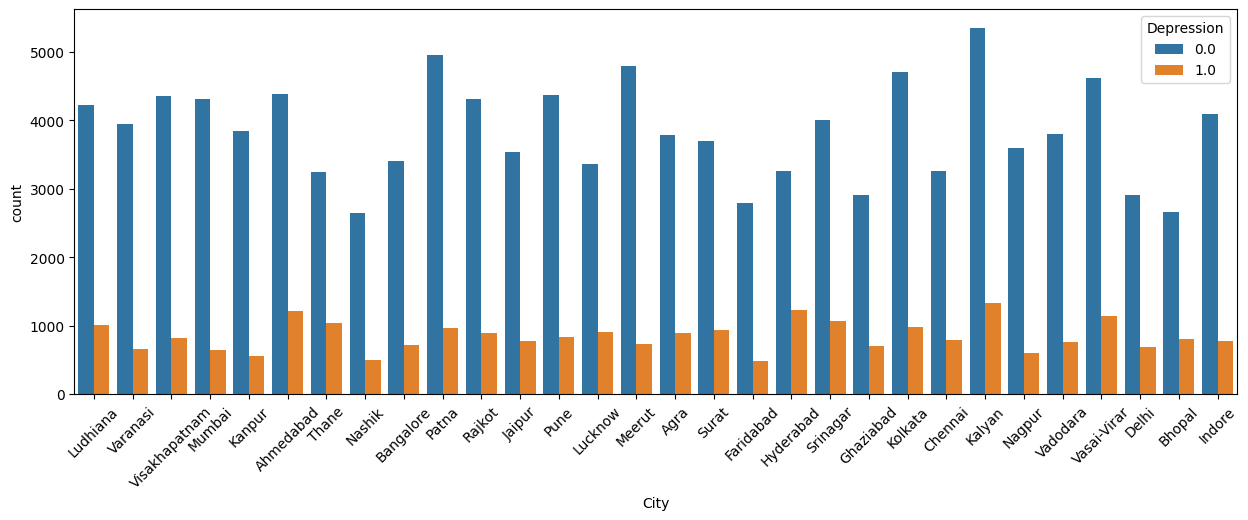

In [521]:
fig,axes=plt.subplots(figsize=(15,5))
sns.countplot(data,x="City",hue="Depression",ax=axes)
axes.tick_params(axis='x', rotation=45)

In [522]:
data = data.drop("City",axis=1)

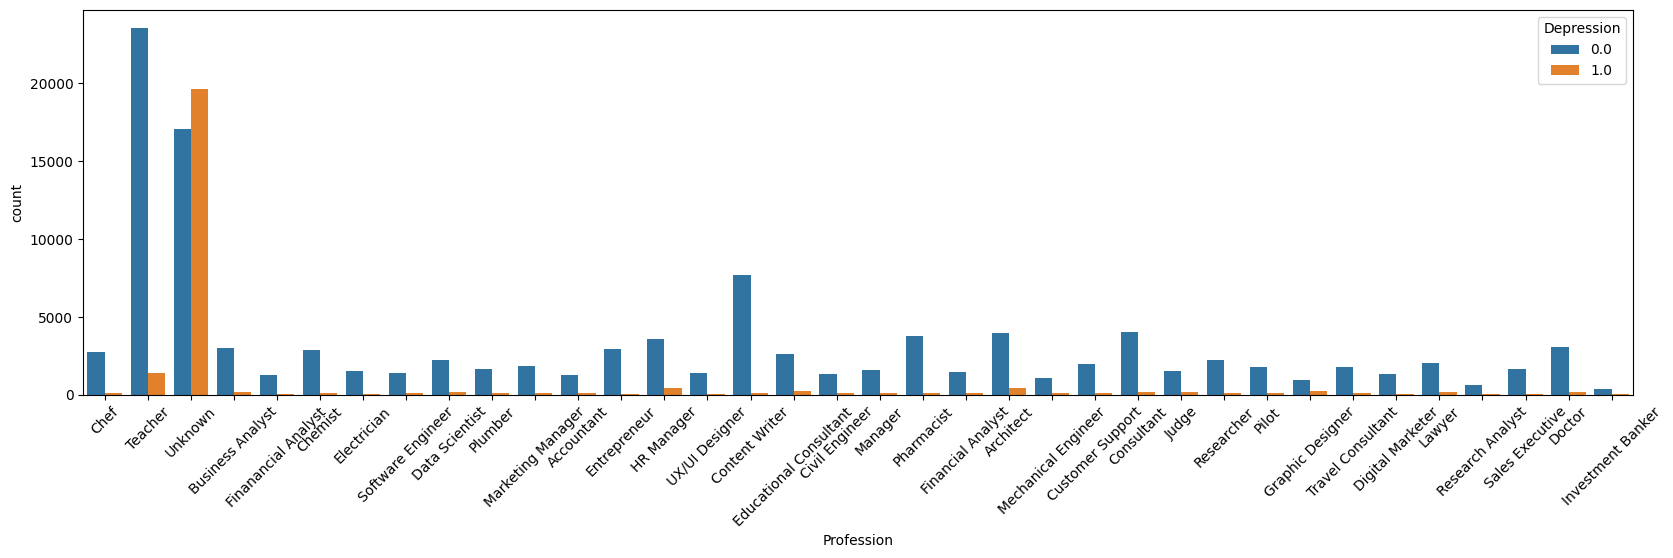

In [523]:
fig,axes=plt.subplots(figsize=(20,5))
sns.countplot(data,x="Profession",hue="Depression",ax=axes)
axes.tick_params(axis='x', rotation=45)

In [524]:
data['Profession'] = data['Profession'].replace('Finanancial Analyst', 'Financial Analyst') # fix more artifacts

data["Profession_Unknown"] = data['Profession'].isin(["Unknown"])
data["Profession_Analyst"] = data['Profession'].isin(["Business Analyst", "Financial Analyst", "Research Analyst"])
data["Engineer"] = data['Profession'].isin(["Software Engineer", "Civil Engineer", "Mechanical Engineer"])
data["Manager"] = data['Profession'].isin(["Marketing Manager", "HR Manager", "Manager"])
data["Designer"] = data['Profession'].isin(["UX/UI Designer", "Graphic Designer"])
data["Consultant"] = data['Profession'].isin(["Educational Consultant", "Consultant", "Travel Consultant"])

data['Profession_CE'] = data['Profession'].map(data['Profession'].value_counts()) # count encode profession

data = data.drop('Profession', axis=1)

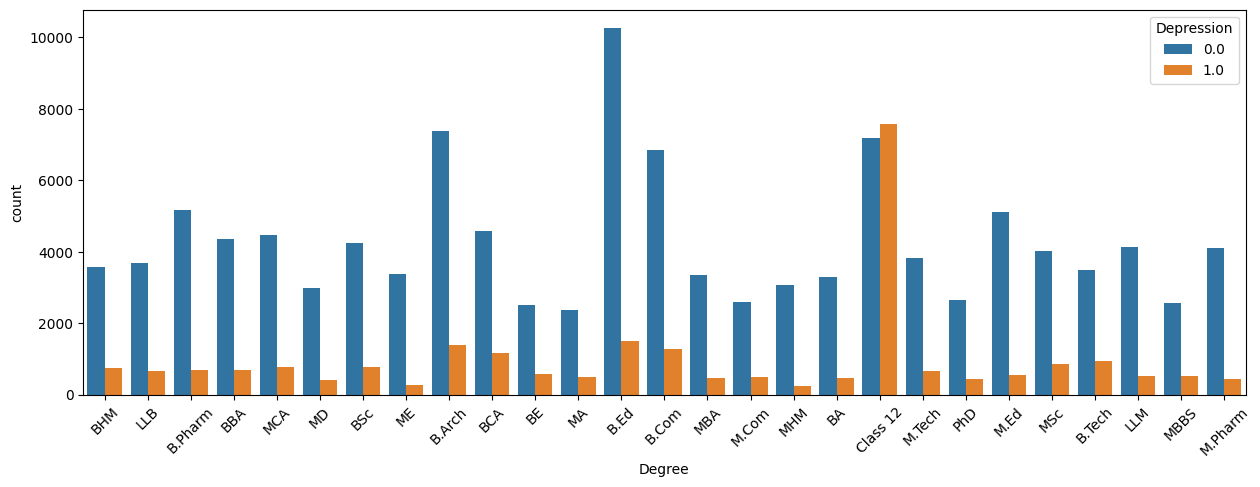

In [525]:
fig,axes=plt.subplots(figsize=(15,5))
sns.countplot(data,x="Degree",hue="Depression",ax=axes)
axes.tick_params(axis='x', rotation=45)

In [526]:
data['Degree_Bachelor'] = data['Degree'].isin(["BHM", "LLB", "B.Pharm", "BBA", "BSc", "B.Arch", "BCA", "BE", "B.Ed", "B.Com", "BA", "B.Tech", "MBBS"])
data['Degree_Master'] = data['Degree'].isin(["MCA", "ME", "MA", "MBA", "M.Com", "MHM", "M.Tech", "M.Ed", "MSc", "LLM", "M.Pharm"])
data['Degree_Doctor'] = data['Degree'].isin(["MD"])
data["Degree_HM"] = data['Degree'].isin(["BHM", "MHM"])
data["Degree_LL"] = data['Degree'].isin(["LLB", "LLM"])
data["Degree_Pharm"] = data['Degree'].isin(["B.Pharm", "M.Pharm"])
data["Degree_BA"] = data['Degree'].isin(["BBA", "MBA"])
data["Degree_CA"] = data['Degree'].isin(["BCA", "MCA"])
data["Degree_Medicine"] = data['Degree'].isin(["MD", "MBBS"])
data["Degree_Sc"] = data['Degree'].isin(["BSc", "MSc"])
data["Degree_E"] = data['Degree'].isin(["BE","ME"])
data["Degree_B.Arch"] = data['Degree'].isin(["B.Arch"])
data["Degree_A"] = data['Degree'].isin(["BA","MA"])
data["Degree_Ed"] = data['Degree'].isin(["B.Ed","M.Ed"])
data["Degree_Com"] = data['Degree'].isin(["B.Com","M.Com"])
data["Degree_Tech"] = data['Degree'].isin(["B.Tech","M.Tech"])

data["Degree_Class_12"] = data['Degree'].isin(["Class 12"])
data = data.drop('Degree', axis=1)

In [527]:
columns = ["Working Professional or Student", "Have you ever had suicidal thoughts ?"]

le = LabelEncoder()

for col in columns:
    data[col] = le.fit_transform(data[col])

In [528]:
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].astype('category')

In [529]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234500 entries, 0 to 234499
Data columns (total 42 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   id                                     234500 non-null  int64   
 1   Gender                                 234500 non-null  category
 2   Age                                    234500 non-null  category
 3   Working Professional or Student        234500 non-null  int32   
 4   Academic Pressure                      234500 non-null  category
 5   Work Pressure                          234500 non-null  category
 6   CGPA                                   234500 non-null  category
 7   Study Satisfaction                     234500 non-null  category
 8   Job Satisfaction                       234500 non-null  category
 9   Sleep Duration                         234500 non-null  category
 10  Dietary Habits                         23450

In [530]:
data = pd.get_dummies(data, columns=["Age", "Academic Pressure", "Work Pressure", "CGPA", "Study Satisfaction", "Job Satisfaction", "Sleep Duration", "Dietary Habits", "Work/Study Hours", "Financial Stress"])
# one hot encode

In [531]:
for col in data.select_dtypes(include='category').columns:
    data[col] = data[col].cat.codes.astype(bool)

for col in data.select_dtypes(include='int32').columns:
    data[col] = data[col].astype(bool)

# convert rest of boolean category types to boolean type

In [532]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234500 entries, 0 to 234499
Columns: 117 entries, id to Financial Stress_5.0
dtypes: bool(112), float64(1), int64(4)
memory usage: 34.0 MB


In [533]:
data.columns = data.columns.str.replace(',', '_')
data.columns = data.columns.str.replace('[', '_')
data.columns = data.columns.str.replace(']', '_')
# replace illegal characters with underscore

In [534]:
train_data = data[data['Depression'].notna()]
test_data = data[data['Depression'].isna()]
test_data = test_data.drop('Depression', axis=1)

test_id = test_data[['id']].copy()
train_data = train_data.drop('id', axis=1)
test_data = test_data.drop('id', axis=1)

In [535]:
X = train_data.drop('Depression', axis=1)
y = (train_data['Depression'] == True)

In [536]:
kf = KFold(n_splits=5, shuffle=False)

In [537]:
param_grid = {"max_iter": [1000,1500,2000,2500,3000]}
logistic_gs = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=kf, refit=True, verbose=3, n_jobs=-1)
logistic_gs.fit(X, y)

print("Best parameters:", logistic_gs.best_params_)
print("Best CV accuracy:", logistic_gs.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'max_iter': 1000}
Best CV accuracy: 0.9387633262260128


In [47]:
param_grid = {"max_depth": [2,3,4,5,10,20,25,30,35,40,50,None]}
hgbc_gs = GridSearchCV(HistGradientBoostingClassifier(max_iter=500), param_grid=param_grid, cv=kf, refit=True, verbose=3, n_jobs=-1)
hgbc_gs.fit(X, y)

print("Best parameters:", hgbc_gs.best_params_)
print("Best CV accuracy:", hgbc_gs.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'max_depth': 3}
Best CV accuracy: 0.9391186922530206


In [48]:
param_grid = {"max_depth": [20,25,30,50,None]}
rf_gs = GridSearchCV(RandomForestClassifier(n_jobs=-1, n_estimators=1000), param_grid=param_grid, cv=kf, refit=True, verbose=3, n_jobs=-1)
rf_gs.fit(X, y)

print("Best parameters:", rf_gs.best_params_)
print("Best CV accuracy:", rf_gs.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'max_depth': None}
Best CV accuracy: 0.9345486851457002


In [49]:
xgb_model = XGBClassifier(n_jobs=-1,device="cuda") # use nvidia cuda supported gpu
param_grid = {"max_depth": [4,10,15,30,50,None]}
xgb_gs = GridSearchCV(xgb_model, param_grid=param_grid, cv=kf, refit=True, verbose=3, n_jobs=-1)
xgb_gs.fit(X, y)

print("Best parameters:", xgb_gs.best_params_)
print("Best CV accuracy:", xgb_gs.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'max_depth': 4}
Best CV accuracy: 0.9386780383795308


In [50]:
lgbm_model = LGBMClassifier(n_jobs=-1,device="gpu",gpu_platform_id = 1,gpu_device_id = 0) # choose platform_id 1 as it's the nvidia gpu platform for me
param_grid = {"max_depth": [4,10,20,25,30,40,50,None], "learning_rate": [0.01,0.1]}
lgbm_gs = GridSearchCV(lgbm_model, param_grid=param_grid, cv=kf, refit=True, verbose=3, n_jobs=-1)
lgbm_gs.fit(X, y)

print("Best parameters:", lgbm_gs.best_params_)
print("Best CV accuracy:", lgbm_gs.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 25567, number of negative: 115133
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 140700, number of used features: 178
[LightGBM] [Info] Using requested OpenCL platform 1 device 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 18 dense feature groups (2.68 MB) transferred to GPU in 0.007157 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181713 -> initscore=-1.504786
[LightGBM] [Info] Start training from score -1.504786
Best parameters: {'max_depth': 30}
Best CV accuracy: 0.938670931

In [51]:
cb_model = CatBoostClassifier(silent=True, verbose=False, logging_level='Silent', allow_writing_files=False, save_snapshot=False, thread_count=-1, task_type="GPU")
param_grid = {"depth": [4,10,20,25,30,40,50,None], "learning_rate": [0.01,0.1]}
cb_gs = GridSearchCV(cb_model, param_grid=param_grid, cv=kf, refit=True, n_jobs=-1)
cb_gs.fit(X, y)

print("Best parameters:", xgb_gs.best_params_)
print("Best CV accuracy:", xgb_gs.best_score_)

Learning rate set to 0.085164
0:	learn: 0.5842324	total: 151ms	remaining: 2m 31s
1:	learn: 0.5051997	total: 168ms	remaining: 1m 23s
2:	learn: 0.4451741	total: 185ms	remaining: 1m 1s
3:	learn: 0.3987555	total: 203ms	remaining: 50.4s
4:	learn: 0.3610406	total: 220ms	remaining: 43.7s
5:	learn: 0.3336401	total: 235ms	remaining: 38.9s
6:	learn: 0.3119815	total: 249ms	remaining: 35.4s
7:	learn: 0.2940362	total: 267ms	remaining: 33s
8:	learn: 0.2819596	total: 283ms	remaining: 31.1s
9:	learn: 0.2702175	total: 300ms	remaining: 29.7s
10:	learn: 0.2623593	total: 315ms	remaining: 28.3s
11:	learn: 0.2544988	total: 331ms	remaining: 27.3s
12:	learn: 0.2486397	total: 346ms	remaining: 26.3s
13:	learn: 0.2422172	total: 362ms	remaining: 25.5s
14:	learn: 0.2377216	total: 378ms	remaining: 24.8s
15:	learn: 0.2328329	total: 395ms	remaining: 24.3s
16:	learn: 0.2297218	total: 413ms	remaining: 23.9s
17:	learn: 0.2257383	total: 432ms	remaining: 23.6s
18:	learn: 0.2225959	total: 449ms	remaining: 23.2s
19:	learn: 

In [57]:
soft_voting_clf = VotingClassifier(estimators=[('logistic', logistic_gs.best_estimator_), 
                                     ('hgbc', hgbc_gs.best_estimator_), 
                                     ('xgb', xgb_gs.best_estimator_), 
                                     ('lgbm', lgbm_gs.best_estimator_),
                                     ('cb', cb_gs.best_estimator_)], 
                                     voting='soft')

soft_voting_clf.fit(X, y)
score = cross_val_score(soft_voting_clf, X, y, cv=kf)
print("Ensemble accuracy:", score.mean())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 25567, number of negative: 115133
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 140700, number of used features: 178
[LightGBM] [Info] Using requested OpenCL platform 1 device 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 18 dense feature groups (2.68 MB) transferred to GPU in 0.004478 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181713 -> initscore=-1.504786
[LightGBM] [Info] Start training from score -1.504786
Learning rate set to 0.085164
0:	learn: 0.5842324	total: 12ms	remaining: 12s
1:	learn: 0.5051997	total: 25.3ms	remaining: 12.

In [64]:
def getPrediction(estimator, test_id, test_data, target):
    y_pred_submission = estimator.predict(test_data)
    
    test_submission = test_id
    test_submission[target] = y_pred_submission

    return test_submission

In [65]:
estimators = [logistic_gs.best_estimator_, hgbc_gs.best_estimator_, rf_gs.best_estimator_, xgb_gs.best_estimator_, lgbm_gs.best_estimator_, cb_gs.best_estimator_]
estimator_names = ["logistic", "hgbc", "rf", "xgb", "lgbm", "cb"]

for estimator, estimator_name in zip(estimators, estimator_names):
    test_submission = getPrediction(estimator, test_id, test_data, "Depression")
    test_submission.to_csv(f"{estimator_name}_submission.csv", index=False)

In [66]:
test_submission = getPrediction(soft_voting_clf, test_id, test_data, "Depression")
test_submission.to_csv("voting_ensemble_submission.csv", index=False)

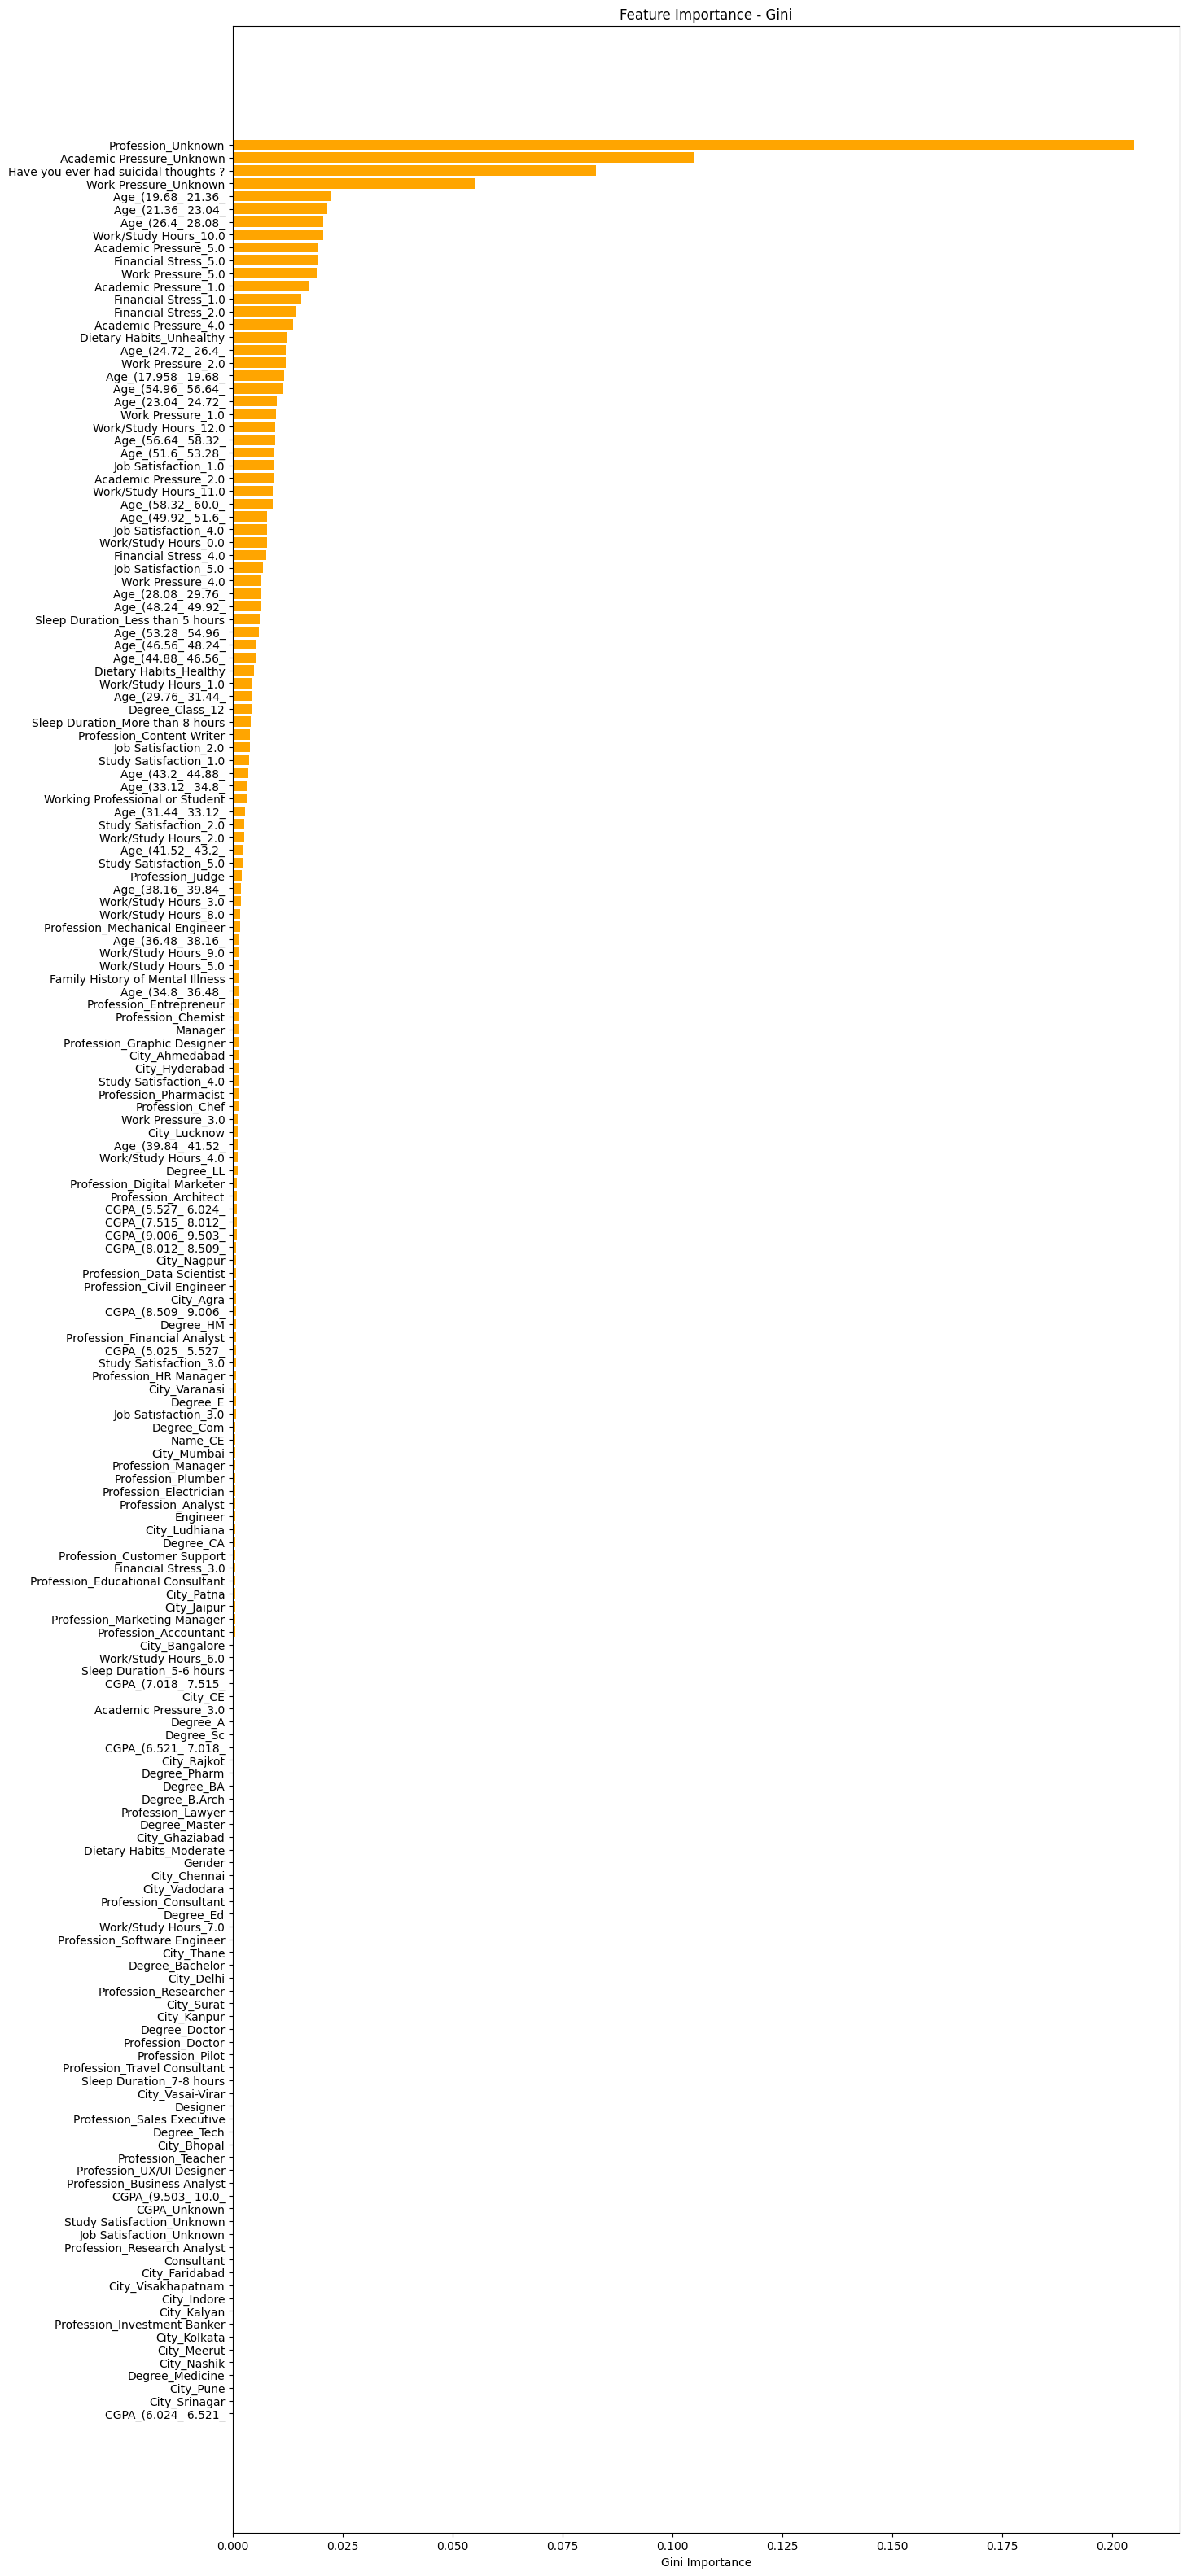

In [68]:
feature_names = list(test_data.columns)
ft_importances = xgb_gs.best_estimator_.feature_importances_ # use xgboost classifier

sorted_idx = np.argsort(ft_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importances = ft_importances[sorted_idx]

plt.figure(figsize=(15, 40))
plt.barh(sorted_features, sorted_importances, color='orange')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini')
plt.gca().invert_yaxis()
plt.show()